# Import libraries

In [1]:
# Data manipulation 
import pandas as pd

# Dates handling
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta

# Chart modules
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool
output_notebook()

# Linear algrebra
import numpy as np
import pywt
import math

# ML
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Technical indicators
from modules.Utils.indicators import addIndicators, computeSuperTrend
from modules.Utils.utils import loadFromDB

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Filtering
from scipy.signal import savgol_filter

# Kucoin
from kucoin.client import Market
client = Market(url='https://api.kucoin.com')

Loading BokehJS ...

# Utils

In [3]:
SYMBOL='BTC'
df = loadFromDB(SYMBOL,'1d')
df = df.iloc[1:]
df['Date'] = df['Date'].apply(lambda x: int(str(x)[:-3]))
df = df.astype(float)
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')
df = addIndicators(df)
df.head()

,Open,High,Low,Close,Volume,Timestamp,EMA20,EMA50,EMA100,EMA200,...,Vortex,Bollinger_low,Bollinger_high,ADX,CCI,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,ST_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-09 02:00:00,466.921,468.499,440.772,459.430,4728.335062,1620518400,440.385332,410.311413,366.788358,286.066771,...,0.173459,541.806951,311.478749,23.063532,-4.132246,429.193679,1.084429,0.515482,0.568947,True
2021-05-10 02:00:00,459.430,482.100,396.308,433.778,9199.474499,1620604800,439.756063,411.231671,368.114885,287.536535,...,0.195873,541.445781,319.122219,21.588067,-94.033759,433.122449,0.915384,0.529455,0.385929,True
2021-05-11 02:00:00,433.649,459.213,417.345,457.878,6252.970833,1620691200,441.481961,413.060939,369.892373,289.231475,...,0.149902,541.191786,330.038514,20.217993,-72.689323,436.494765,0.778606,0.547212,0.231393,True
2021-05-12 02:00:00,457.494,597.337,456.193,503.712,58164.268218,1620777600,447.408632,416.615883,372.542266,291.365609,...,0.275178,546.326776,339.301724,21.489581,172.261679,439.769194,0.750165,0.574588,0.175576,True
2021-05-13 02:00:00,501.456,620.767,450.041,509.662,62360.468527,1620864000,453.337524,420.264750,375.257509,293.537713,...,0.329461,547.821248,354.450752,22.947021,152.272119,443.212107,0.782891,0.612940,0.169951,True


# High higher than preivous close

Distribution (True = High of day i higher than Close of day i-1): 
True     472
False      4
Name: Higher_high, dtype: int64
Total True percentage : 99.16%

For the whole dataset :

- Average percentage the next high when it's higher than previous close : 5.28%
- Standard deviation percentage the next high when it's higher than previous close : 5.54%
- Median percentage the next high when it's higher than previous close : 3.77%
- Quantile 25 percentage the next high when it's higher than previous close : 1.59%

For the ideal dataset :

- Average percentage the next high when it's higher than previous close : 5.33%
- Standard deviation percentage the next high when it's higher than previous close : 5.55%
- Median percentage the next high when it's higher than previous close : 3.8%
- Quantile 25 percentage the next high when it's higher than previous close : 1.61%


<AxesSubplot:title={'center':'Corresponding boxplot'}, xlabel='High_pct_change'>

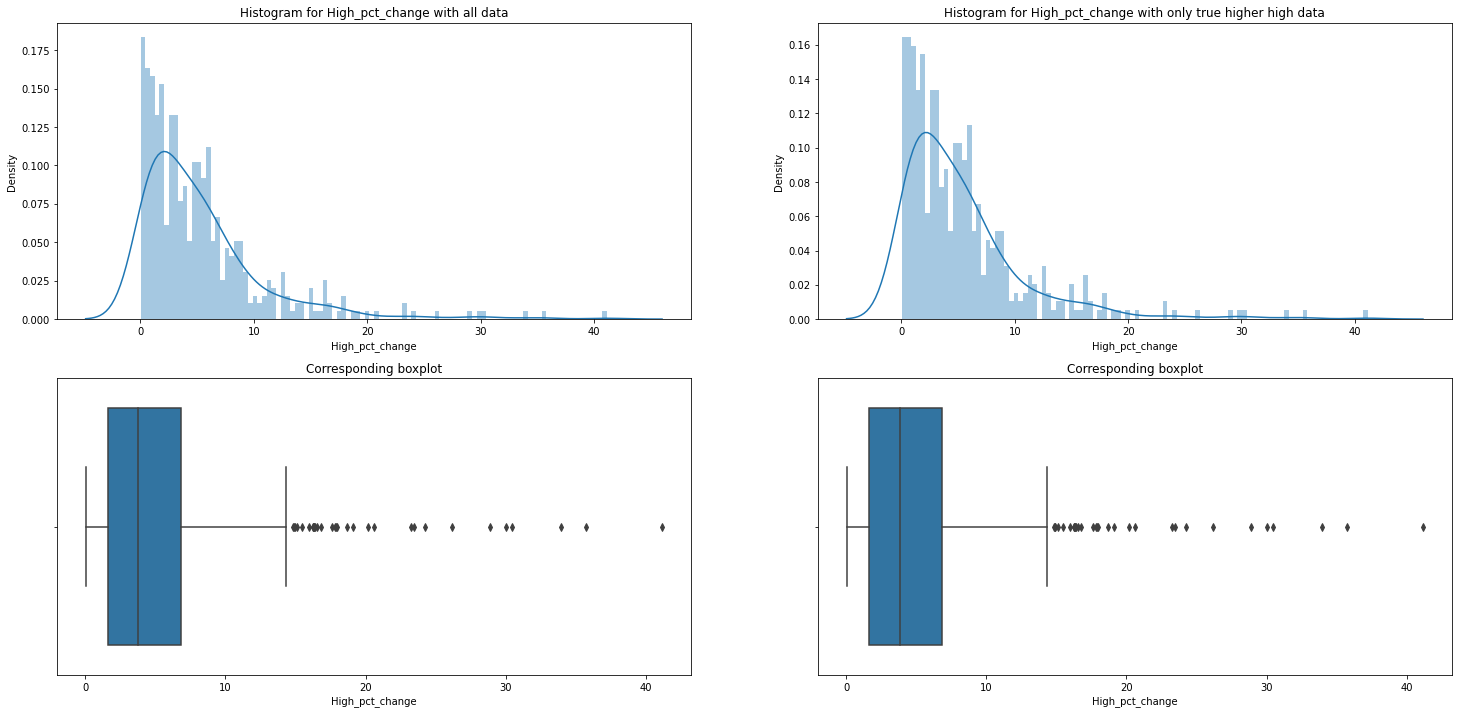

In [4]:
df['Higher_high'] = np.nan
df['Higher_high'].iloc[1:] = [df['High'].iloc[i]>df['Close'].iloc[i-1] for i in range(1,len(df))]
df['High_pct_change'] = np.nan
df['High_pct_change'].iloc[1:] = [100*abs(df['Close'].iloc[i-1]-df['High'].iloc[i])/df['Close'].iloc[i-1] for i in range(1,len(df))]
df['Change'] = df.Close.pct_change()*100
df.dropna(inplace=True)
print(f"Distribution (True = High of day i higher than Close of day i-1): \n{df['Higher_high'].value_counts()}")
print(f"Total True percentage : {round(100*len(df[df['Higher_high']==True])/len(df),2)}%")

print('\nFor the whole dataset :')
print(f"\n- Average percentage the next high when it's higher than previous close : {round(df['High_pct_change'].mean(),2)}%")
print(f"- Standard deviation percentage the next high when it's higher than previous close : {round(df['High_pct_change'].std(),2)}%")
print(f"- Median percentage the next high when it's higher than previous close : {round(df['High_pct_change'].median(),2)}%")
print(f"- Quantile 25 percentage the next high when it's higher than previous close : {round(df['High_pct_change'].quantile(q=0.25),2)}%")
print('\nFor the ideal dataset :')
print(f"\n- Average percentage the next high when it's higher than previous close : {round(df[df['Higher_high']==True]['High_pct_change'].mean(),2)}%")
print(f"- Standard deviation percentage the next high when it's higher than previous close : {round(df[df['Higher_high']==True]['High_pct_change'].std(),2)}%")
print(f"- Median percentage the next high when it's higher than previous close : {round(df[df['Higher_high']==True]['High_pct_change'].median(),2)}%")
print(f"- Quantile 25 percentage the next high when it's higher than previous close : {round(df[df['Higher_high']==True]['High_pct_change'].quantile(q=0.25),2)}%")


fig, ax1 = plt.subplots(2,2,figsize=(25,12))
ax1[0,0].set_title(f'Histogram for High_pct_change with all data')
sns.distplot(df.High_pct_change, hist=True,ax=ax1[0,0],bins=100)
ax1[1,0].set_title(f'Corresponding boxplot')
sns.boxplot(df.High_pct_change,ax=ax1[1,0])

ax1[0,1].set_title(f'Histogram for High_pct_change with only true higher high data')
sns.distplot(df[df['Higher_high']==True].High_pct_change, hist=True,ax=ax1[0,1],bins=100)
ax1[1,1].set_title(f'Corresponding boxplot')
sns.boxplot(df[df['Higher_high']==True].High_pct_change,ax=ax1[1,1])

In [5]:
tp = df['High_pct_change'].quantile(q=0.25)/100
leverage = 1
equity = 50
gain = 0

df['WIN_LONG'] = np.nan
for i in range(1,len(df)): 
    #if df['ST_Direction'].iloc[i]==True:
        if df['High'].iloc[i]>=df['Close'].iloc[i-1]*(1+tp):
            df['WIN_LONG'].iloc[i] = True
            gain = gain + equity*(tp*leverage)
        else:
            df['WIN_LONG'].iloc[i] = False
            gain = gain - equity*(tp*leverage)
        
            
print(f'Starting equity : {equity} USDT')
print(f'Total pure gain {round(gain,2)} USDT')
print(f'Final balance {round(gain,2)+equity} USDT x{round((gain+equity)/equity,2)} ')
print(f'Winrate {round(100*df.WIN_LONG.value_counts()[1]/(df.WIN_LONG.value_counts()[1]+df.WIN_LONG.value_counts()[0]),2)} %')

df.WIN_LONG.value_counts()

Starting equity : 50 USDT
Total pure gain 187.93 USDT
Final balance 237.93 USDT x4.76 
Winrate 74.95 %


True     356
False    119
Name: WIN_LONG, dtype: int64

# Low Lower than preivous close

Distribution (True = Low of day i Lower than Close of day i-1): 
True     474
False      1
Name: Lower_low, dtype: int64
Total True percentage : 99.79%

For the whole dataset :

- Average percentage the next high when it's higher than previous close : 5.28%
- Standard deviation percentage the next high when it's higher than previous close : 5.55%
- Median percentage the next high when it's higher than previous close : 3.76%
- Quantile 25 percentage the next high when it's higher than previous close : 1.59%

For the ideal dataset :

- Average percentage the next high when it's higher than previous close : 5.27%
- Standard deviation percentage the next high when it's higher than previous close : 5.54%
- Median percentage the next high when it's higher than previous close : 3.76%
- Quantile 25 percentage the next high when it's higher than previous close : 1.59%


<AxesSubplot:title={'center':'Corresponding boxplot'}, xlabel='Low_pct_change'>

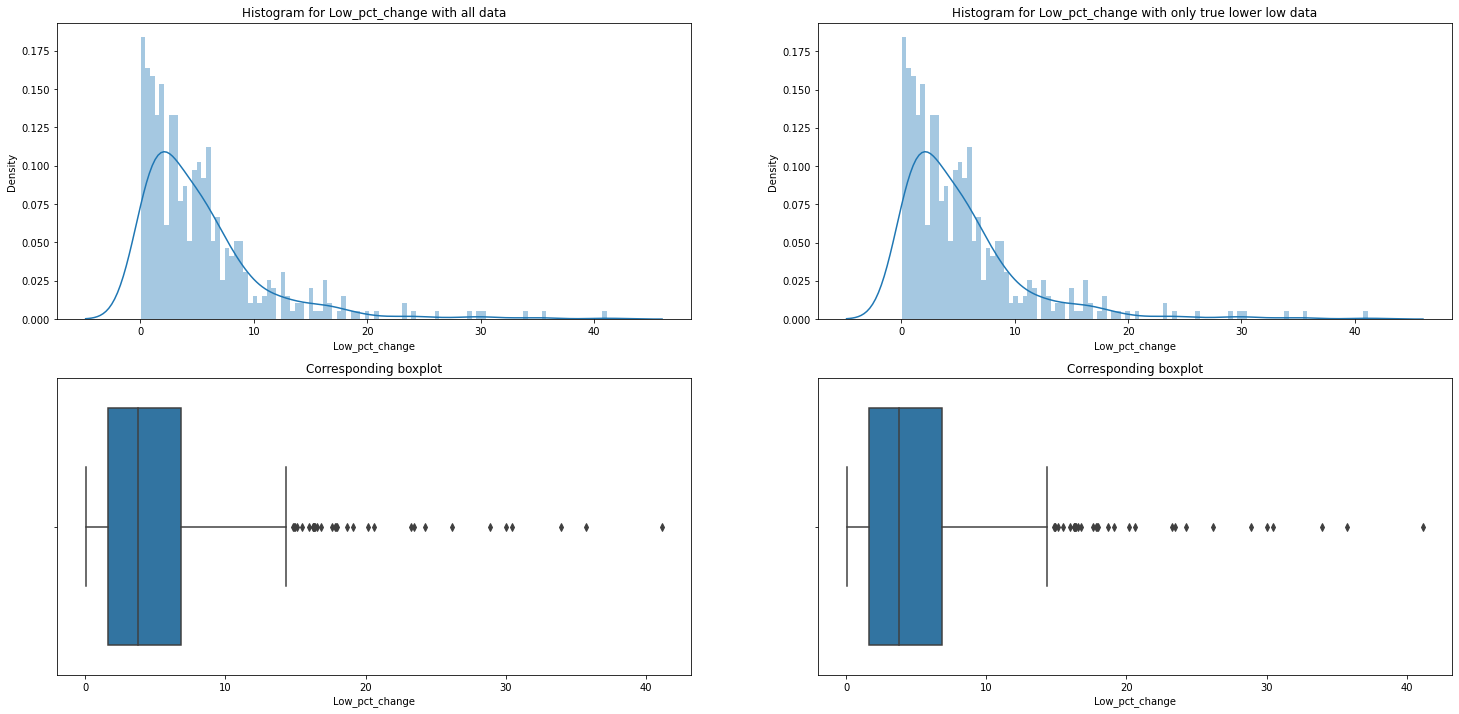

In [6]:
df['Lower_low'] = np.nan
df['Lower_low'].iloc[1:] = [df['Low'].iloc[i]<df['Close'].iloc[i-1] for i in range(1,len(df))]
df['Low_pct_change'] = np.nan
df['Low_pct_change'].iloc[1:] = [100*abs(df['Close'].iloc[i-1]-df['High'].iloc[i])/df['Close'].iloc[i-1] for i in range(1,len(df))]
df.dropna(inplace=True)
print(f"Distribution (True = Low of day i Lower than Close of day i-1): \n{df['Lower_low'].value_counts()}")
print(f"Total True percentage : {round(100*len(df[df['Lower_low']==True])/len(df),2)}%")

print('\nFor the whole dataset :')
print(f"\n- Average percentage the next high when it's higher than previous close : {round(df['Low_pct_change'].mean(),2)}%")
print(f"- Standard deviation percentage the next high when it's higher than previous close : {round(df['Low_pct_change'].std(),2)}%")
print(f"- Median percentage the next high when it's higher than previous close : {round(df['Low_pct_change'].median(),2)}%")
print(f"- Quantile 25 percentage the next high when it's higher than previous close : {round(df['Low_pct_change'].quantile(q=0.25),2)}%")
print('\nFor the ideal dataset :')
print(f"\n- Average percentage the next high when it's higher than previous close : {round(df[df['Lower_low']==True]['Low_pct_change'].mean(),2)}%")
print(f"- Standard deviation percentage the next high when it's higher than previous close : {round(df[df['Lower_low']==True]['Low_pct_change'].std(),2)}%")
print(f"- Median percentage the next high when it's higher than previous close : {round(df[df['Lower_low']==True]['Low_pct_change'].median(),2)}%")
print(f"- Quantile 25 percentage the next high when it's higher than previous close : {round(df[df['Lower_low']==True]['Low_pct_change'].quantile(q=0.25),2)}%")


fig, ax1 = plt.subplots(2,2,figsize=(25,12))
ax1[0,0].set_title(f'Histogram for Low_pct_change with all data')
sns.distplot(df.Low_pct_change, hist=True,ax=ax1[0,0],bins=100)
ax1[1,0].set_title(f'Corresponding boxplot')
sns.boxplot(df.Low_pct_change,ax=ax1[1,0])

ax1[0,1].set_title(f'Histogram for Low_pct_change with only true lower low data')
sns.distplot(df[df['Lower_low']==True].Low_pct_change, hist=True,ax=ax1[0,1],bins=100)
ax1[1,1].set_title(f'Corresponding boxplot')
sns.boxplot(df[df['Lower_low']==True].Low_pct_change,ax=ax1[1,1])

In [7]:
tp = df['Low_pct_change'].quantile(q=0.25)/100
leverage = 5
equity = 1000
gain = 0

df['WIN_SHORT'] = np.nan
for i in range(1,len(df)): 
        if df['Low'].iloc[i]<=df['Close'].iloc[i-1]*(1-tp):
            df['WIN_SHORT'].iloc[i] = True
            gain = gain + equity*(tp*leverage)
        else:
            df['WIN_SHORT'].iloc[i] = False
            gain = gain - equity*(tp*leverage)
            
print(f'Starting equity : {equity} USDT')
print(f'Total pure gain {round(gain,2)} USDT')
print(f'Final balance {round(gain,2)+equity} USDT x{round((gain+equity)/equity,2)} ')
print(f'Winrate {round(100*df.WIN_SHORT.value_counts()[1]/(df.WIN_SHORT.value_counts()[1]+df.WIN_SHORT.value_counts()[0]),2)} %')
df.WIN_SHORT.value_counts()

Starting equity : 1000 USDT
Total pure gain 24260.93 USDT
Final balance 25260.93 USDT x25.26 
Winrate 82.28 %


True     390
False     84
Name: WIN_SHORT, dtype: int64

Period : [2021-05-11 02:00:00] -> [2022-08-28 02:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 1442.66 $
Performance vs US Dollar : 44.27 %
Buy and Hold Performence : -82.3 %
Performance vs Buy and Hold : -153.78 %
Best trade : +1.57 %, the 2021-07-10 02:00:00
Worst trade : -12.19 %, the 2022-08-19 02:00:00
Worst drawBack : -16.0 %
Total fees :  110.82 $

----- Trades Informations -----
Total trades on period : 81
Number of positive trades : 69
Number of negative trades :  12
Trades win rate ratio : 85.19 %
Average trades performance : 0.56 %
Average positive trades : 1.55 %
Average negative trades : -5.15 %

----- Plot -----


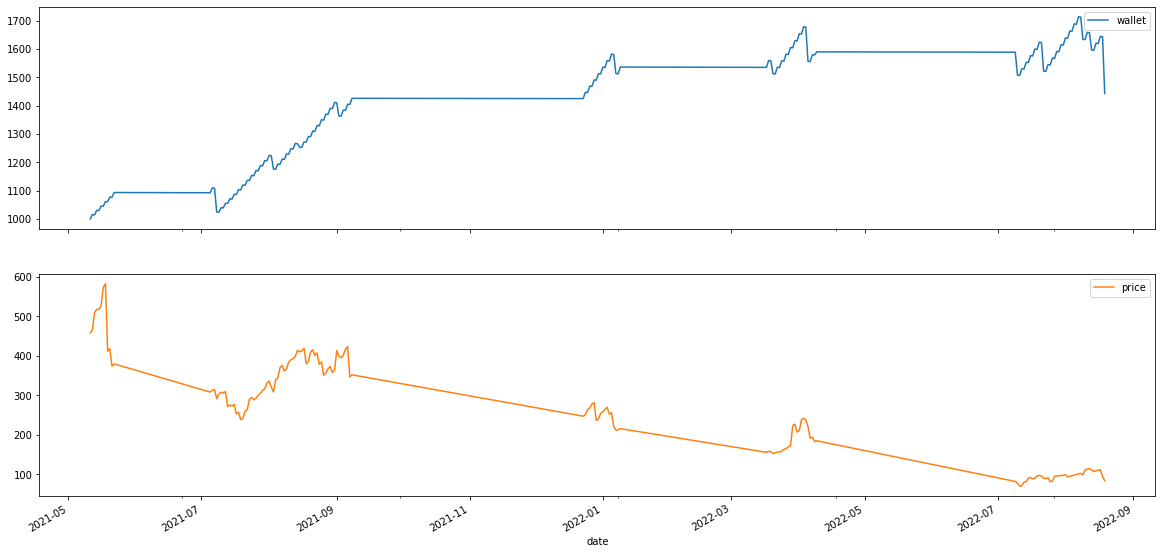

In [8]:
from modules.Utils.utils import strategyTester
from modules.Utils.indicators import computeSuperTrend


def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row['ST_Direction']==True else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True

strategyTester(df.iloc[-2000:],buyCondition,sellCondition,equity=1000,take_profit=True,tp=df['Low_pct_change'].quantile(q=0.25)/100)